In [ ]:
import os
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV

In [60]:
os.environ["LOKY_MAX_CPU_COUNT"] = "12"

In [61]:
DATA_PATH = Path("Data/dataset.csv")
df = pd.read_csv(DATA_PATH, low_memory=False)

In [62]:
rf = joblib.load("Models/RF/rf.pkl")

In [63]:
df = df[df["grav"].notna()]
df = df[df["an_nais"].between(1920, 2023)]
df["age"] = df["year"] - df["an_nais"]

In [64]:
df["catv"] = df["catv"].replace({
    "Motocyclette": "2RM",
    "Scooter_125_cm3": "2RM",
    "Moto_125_cm3": "2RM",
    "Vélo": "Vélo",
    "Voiture": "VP",
    "Quad léger": "Quad",
    "Fourgon": "Utilitaire",
    "Poids lourd 3.5t à 7.5t": "PL",
    "Poids lourd > 7.5t": "PL",
    "Tracteur routier": "PL",
    "Autobus": "Transport",
    "Autocar": "Transport",
    "Engin spécial": "Spécial",
    "Tramway": "Spécial"
})

In [65]:
cols_to_drop = [
    "Num_Acc", "id_usager", "id_vehicule", "num_veh_x", "num_veh_y", "adr",
    "lat", "long", "v1", "v2", "voie", "pr", "pr1", "motor", "occutc", "hrmn"
]
df.drop(columns=[col for col in cols_to_drop if col in df.columns], inplace=True)

In [66]:
def group_rare_modalities(series, threshold=50):
    counts = series.value_counts()
    rare = counts[counts < threshold].index
    return series.apply(lambda x: "Autre" if x in rare else x)

categorical_cols = df.select_dtypes(include="object").columns
for col in categorical_cols:
    df[col] = group_rare_modalities(df[col], threshold=50)

In [67]:
selected_cols = [
    "sexe", "catu", "catv", "atm", "lum", "col", "choc",
    "manv", "plan", "surf", "nbv", "secu1", "infra", "place", "age"
]

X = df[selected_cols]
y = df["grav"]

le = LabelEncoder()
y_encoded = le.fit_transform(y)

value_counts = pd.Series(y_encoded).value_counts()
valid_classes = value_counts[value_counts >= 2].index
mask = np.isin(y_encoded, valid_classes)

X = X.iloc[mask].reset_index(drop=True)
y_encoded = y_encoded[mask]

le = LabelEncoder()
y_encoded = le.fit_transform(y_encoded)

X_encoded = pd.get_dummies(X.astype(str), drop_first=True)
X_encoded = X_encoded.astype(float)
X_encoded = X_encoded.loc[:, ~X_encoded.columns.duplicated()]
X_encoded.columns = (
    X_encoded.columns
    .str.replace(r"[\[\]<>\"'{}:|,=]", "", regex=True)
    .str.replace(r"\\s+", "_", regex=True)
    .str.replace(r"[^0-9a-zA-Z_]", "", regex=True)
)

In [68]:
if "age" in X_encoded.columns:
    scaler = StandardScaler()
    X_encoded[["age"]] = scaler.fit_transform(X_encoded[["age"]])

In [ ]:
y_binary = (y_encoded == 3).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

rf = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [70]:
importances = pd.Series(rf.feature_importances_, index=X_encoded.columns).sort_values(ascending=False)
top_features = importances.head(20)

              precision    recall  f1-score   support

           0       0.99      0.71      0.83    126256
           1       0.07      0.77      0.12      3385

    accuracy                           0.71    129641
   macro avg       0.53      0.74      0.48    129641
weighted avg       0.97      0.71      0.81    129641



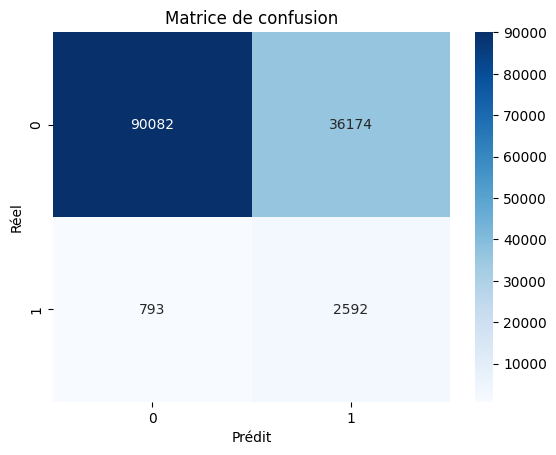

Faux négatifs pour la classe 3 : 793
Bons positifs pour la classe 3 : 2592


In [71]:
model = HistGradientBoostingClassifier(random_state=42, class_weight="balanced")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Matrice de confusion")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()

df_eval = pd.DataFrame({
    "y_true": y_test,
    "y_pred": y_pred
})

false_neg_3 = df_eval[(df_eval["y_true"] == 1) & (df_eval["y_pred"] == 0)]
true_pos_3 = df_eval[(df_eval["y_true"] == 1) & (df_eval["y_pred"] == 1)]

print(f"Faux négatifs pour la classe 3 : {len(false_neg_3)}")
print(f"Bons positifs pour la classe 3 : {len(true_pos_3)}")

In [72]:
print("Distribution y_test :", pd.Series(y_test).value_counts())
print("Nb de classe 3 dans y_encoded :", (y_encoded == 3).sum())
print("Extrait y_test :", y_test[:10])

Distribution y_test : 0    126256
1      3385
Name: count, dtype: int64
Nb de classe 3 dans y_encoded : 16926
Extrait y_test : [0 0 0 0 0 0 0 0 1 0]


In [73]:
Path("Models/RF").mkdir(parents=True, exist_ok=True)
joblib.dump(rf, "Models/RF/rf.pkl")

['Models/RF/rf.pkl']